In [1]:
import sys
sys.path.append('../src')
from logger import log, debug
from cleaner import clean_corpus_basic_neutral
from reader import read_files
from lstm_utils import get_tokenizer, get_best_tokens_dummy

from sklearn.utils import shuffle

from keras.layers import Dense, LSTM
from keras.models import Model, Sequential, load_model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lefunes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lefunes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


In [2]:
# -------------- Hiperparametros -----------------

vector_size = 8
each_q = 128
batch_size = 2000
epoch = 256
min_lenght, max_length = 4, 8
train_to_test = 0.8

In [3]:
# Leemos los archivos
neutral_corpus_raw = pd.read_csv("./samples/neutral_human_rated.csv")
# Limpiamos el dataframe
neutral_corpus = clean_corpus_basic_neutral(neutral_corpus_raw)

# Filtramos por longitud
debug("[El corpus tiene " + str(len(neutral_corpus)) + " rows]")

#Shuffleamos el corpus
neutral_corpus = shuffle(neutral_corpus)
neutral_corpus.reset_index(inplace=True, drop=True)
neutral_corpus.head()


pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)


[Usando cleaner basico para samples neutrales]
[Limpiando el corpus...]
[Usando 8 threads ...]
[El corpus tiene 1000 rows]


In [4]:
# Seleccionamos los mejores tokens
best_tokens = pd.read_pickle("best_tokens.bin")


max_features = best_tokens.size

tokenizer = get_tokenizer(best_tokens, vector_size)

# Vectorizamos
debug("[Vectorizando corpus... ]")
neutral_corpus['vector'] = tokenizer(neutral_corpus['content'])
#del neutral_corpus['content']

debug(best_tokens.size)


[Vectorizando corpus... ]
186


In [5]:
# Extraemos los x
x = np.stack(neutral_corpus["vector"].values)
# Cargamos el model
model = load_model("./model.h5")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [6]:
def to_rate(row):
    percentage = row[0]
    if(percentage <= 1/3):
        return "m"
    if(percentage <= 2/3):
        return "n"
    return "b"

def to_percentage(row):
    percentage = row[0]
    return '%.3f'%(row[0] * 100) + "%"
    

In [7]:
del neutral_corpus["vector"]

In [8]:
# Hacemos prediccion contra el model
y = model.predict(x, batch_size=batch_size)

# Agregamos los resultados al dataframe
neutral_corpus["prediction"] = y.tolist()

# Convertimos el vector en b/n/m
neutral_corpus["percentage"] = neutral_corpus["prediction"].apply(to_percentage)
neutral_corpus["machine_rate"] = neutral_corpus["prediction"].apply(to_rate)

# Vemos cuales fallo
neutral_corpus["failed"] = neutral_corpus["human_rate"] != neutral_corpus["machine_rate"]



,content,raw,human_rate,prediction,percentage,machine_rate,failed
0,BUEN BUEN BIEN BUEN B L,Bueno Buen bien bueno B L,b,"[0.8521620035171509, 0.14783795177936554]",85.216%,b,False
1,TOD BIEN CONFORM TOD BIEN CONFORM,"Todo bien, conforme. Todo bien. Conforme con el producto.",b,"[0.9137623310089111, 0.08623765408992767]",91.376%,b,False
2,BUEN NAD MAS ESPER FUER POC MAS PES GRUES SIENT POC DELIC AUNQU SON ESTET LIND BUEN FIL ESTAN BIEN CEN PER NO RECOM PEL FRUT ALGUN OTRA TARE SIMPL COCIN,"Buenos nada mas Esperaba que fueran un poco mas pesados y gruesos. Se sienten un poco delicados, aunque son esteticamente lindos y de buen filo. Estan bien para la cena, pero no los recomiendo pelar una fruta o alguna otra tarea simple de la cocina.",n,"[0.8443417549133301, 0.15565824508666992]",84.434%,b,True
3,NO VOLVERI COMPR DIFICIL COLOC PAR NO BORR BIEN,No lo volveria comprar Dificil colocarla a la pared. No se borra muy bien.,m,"[0.004333908203989267, 0.9956660270690918]",0.433%,m,False
4,BIEN ESTA BIEN PRECI,Bien Esta bien para el precio .......,b,"[0.6787784099578857, 0.3212215304374695]",67.878%,b,False


In [9]:

# Separamos en 3 categorias
corpus_b = neutral_corpus[neutral_corpus["human_rate"] == "b"].copy()
corpus_n = neutral_corpus[neutral_corpus["human_rate"] == "n"].copy()
corpus_m = neutral_corpus[neutral_corpus["human_rate"] == "m"].copy()

In [24]:
# Contamos el acc de cada cate

corpus_b_count = corpus_b["failed"].value_counts(normalize=True)
corpus_n_count = corpus_n["failed"].value_counts(normalize=True)
corpus_m_count = corpus_m["failed"].value_counts(normalize=True)

log("[El ratio de failed/total de la categoria neutro-bueno es: " + str(corpus_b_count[True]) + "]")
log("[El ratio de failed/total de la categoria neutro-neutro es: " + str(corpus_n_count[True]) + "]")
log("[El ratio de failed/total de la categoria neutro-malo es: " + str(corpus_m_count[True]) + "]")

[El ratio de failed/total de la categoria neutro-bueno es: 0.1857451403887689]
[El ratio de failed/total de la categoria neutro-neutro es: 0.8113695090439277]
[El ratio de failed/total de la categoria neutro-malo es: 0.2080536912751678]


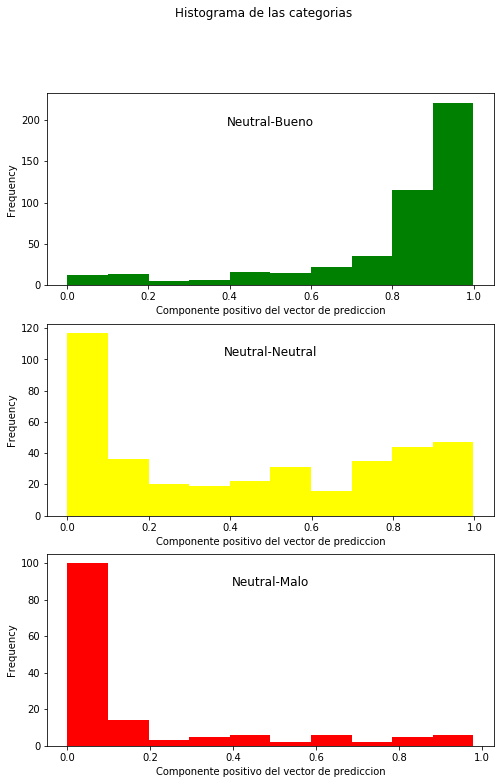

In [63]:
# Histogramas de cada categoria

hist_data_b = corpus_b["prediction"].map(lambda x: x[0])
hist_data_n = corpus_n["prediction"].map(lambda x: x[0])
hist_data_m = corpus_m["prediction"].map(lambda x: x[0])

fig = plt.figure(figsize=(8, 12))
fig.suptitle("Histograma de las categorias")
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

n, bins, patches = ax1.hist(hist_data_b, color='green')
ax1.set_title("Neutral-Bueno", y=0.8)
ax1.set_xlabel('Componente positivo del vector de prediccion')
ax1.set_ylabel('Frequency')

n, bins, patches = ax2.hist(hist_data_n, color='yellow')
ax2.set_title("Neutral-Neutral", y=0.8)
ax2.set_xlabel('Componente positivo del vector de prediccion')
ax2.set_ylabel('Frequency')

n, bins, patches = ax3.hist(hist_data_m, color='red')
ax3.set_title("Neutral-Malo", y=0.8)
ax3.set_xlabel('Componente positivo del vector de prediccion')
ax3.set_ylabel('Frequency')

fig.savefig('./graphs/neutral_histogram.png')

In [92]:
# Vemos acc del la predicción
rates_diff = neutral_corpus[neutral_corpus["human_rate"] != neutral_corpus["machine_rate"]].copy()
rates_ok = neutral_corpus[neutral_corpus["human_rate"] == neutral_corpus["machine_rate"]].copy()


In [83]:
# Vemos cuanto le falta para llegar al human_rate
def get_slack(row):
    hr = row["human_rate"]
    percentage = row["prediction"][0]
    
    human_percentage = 0
    if(hr == "b"):
        # la mitad entre 0 y 1/3
        human_percentage = 0 + (1/3 / 2)
    elif(hr == "n"):
        # la mitad entre 1/3 y 2/3
        human_percentage = 1/3 + (1/3 / 2)
    else:
        # la mitad entre 2/3 y 1
        human_percentage = 2/3 + (1/3 / 2)
    return abs(percentage - human_percentage)

In [93]:

rates_diff["diff"] = rates_diff.apply(lambda x : get_slack(x), axis=1)
rates_ok["diff"] = rates_ok.apply(lambda x : get_slack(x), axis=1)
neutral_corpus["diff"] = neutral_corpus.apply(lambda x : get_slack(x), axis=1)


In [97]:
acc = len(rates_diff.index) * 100 / len(neutral_corpus.index)

debug("acc: " + str(100 - acc))

debug("only diff error mean: " + str(rates_diff["diff"].mean()))
debug("only diff std mean: " + str(rates_diff["diff"].std()))

debug("only ok error mean: " + str(rates_ok["diff"].mean()))
debug("only ok std mean: " + str(rates_ok["diff"].std()))

debug("all corpus error mean: " + str(neutral_corpus["diff"].mean()))
debug("all corpus std mean: " + str(neutral_corpus["diff"].std()))


acc: 56.8
only diff error mean: 0.3469206205387719
only diff std mean: 0.13343732386142287
only ok error mean: 0.6606496186894053
only ok std mean: 0.23764004478198406
all corpus error mean: 0.5251186914883316
all corpus std mean: 0.25280330414007013
